## Fine-tune TrOCR on the IAM Handwriting Database

In this notebook, we are going to fine-tune a pre-trained TrOCR model on the [IAM Handwriting Database](https://fki.tic.heia-fr.ch/databases/iam-handwriting-database), a collection of annotated images of handwritten text.

We will do this using the new `VisionEncoderDecoderModel` class, which can be used to combine any image Transformer encoder (such as ViT, BEiT) with any text Transformer as decoder (such as BERT, RoBERTa, GPT-2). TrOCR is an instance of this, as it has an encoder-decoder architecture, with the weights of the encoder initialized from a pre-trained BEiT, and the weights of the decoder initialized from a pre-trained RoBERTa. The weights of the cross-attention layer were randomly initialized, before the authors pre-trained the model further on millions of (partially synthetic) annotated images of handwritten text.

This figure gives a good overview of the model (from the original paper):

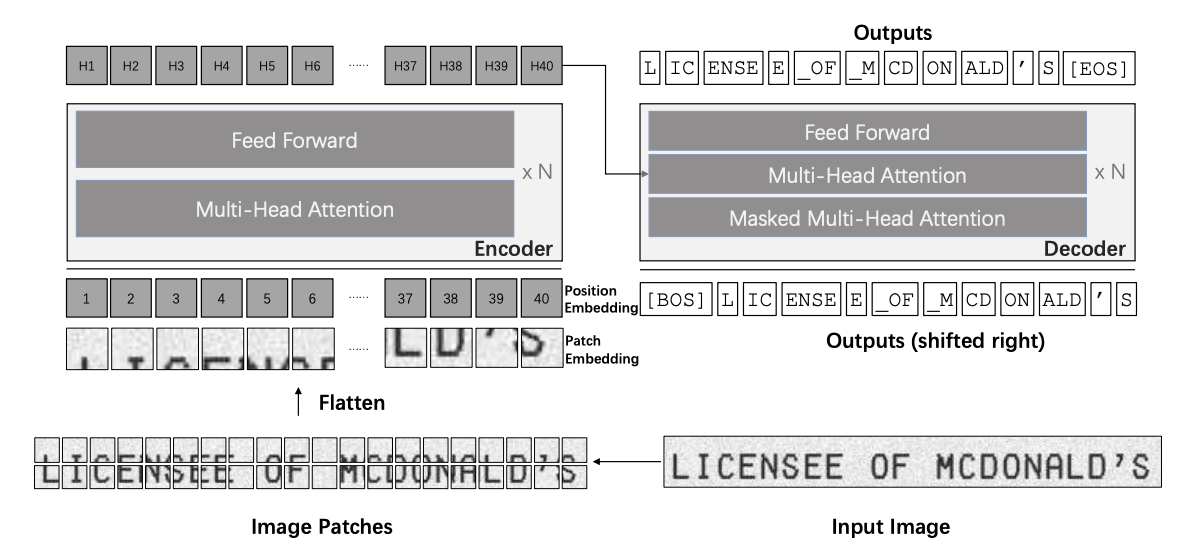

* TrOCR paper: https://arxiv.org/abs/2109.10282
* TrOCR documentation: https://huggingface.co/transformers/master/model_doc/trocr.html


Note that Patrick also wrote a very good [blog post](https://huggingface.co/blog/warm-starting-encoder-decoder) on warm-starting encoder-decoder models (which is what the TrOCR authors did). This blog post was very helpful for me to create this notebook.

We will fine-tune the model using the Seq2SeqTrainer, which is a subclass of the 🤗 Trainer that lets you compute generative metrics such as BLEU, ROUGE, etc by doing generation (i.e. calling the `generate` method) inside the evaluation loop.



## Set-up environment

First, let's install the required libraries:
* Transformers (for the TrOCR model)
* Datasets & Jiwer (for the evaluation metric)

We will not be using HuggingFace Datasets in this notebook for data preprocessing, we will just create a good old basic PyTorch Dataset.

In [1]:
!pip install -q pyarrow==14.0.1

In [2]:
!pip install -q transformers

In [3]:
!pip install -q datasets==2.17.0 jiwer

## Prepare data

We first download the data. Here, I'm just using the IAM test set, as this was released by the TrOCR authors in the unilm repository. It can be downloaded from [this page](https://github.com/microsoft/unilm/tree/master/trocr).

Let's make a [regular PyTorch dataset](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html). We first create a Pandas dataframe with 2 columns. Each row consists of the file name of an image, and the corresponding text.

In [4]:
def download_and_unzip(url, save_path):
    print(f"Downloading and extracting assets....", end="")

    # Downloading zip file using urllib package.
    urlretrieve(url, save_path)

    try:
        # Extracting zip file using the zipfile package.
        with ZipFile(save_path) as z:
            # Extract ZIP file contents in the same directory.
            z.extractall('')

        print("Done")

    except Exception as e:
        print("\nInvalid file.", e)

In [5]:
import os
import os
from urllib.request import urlretrieve
from zipfile import ZipFile

URL = r"https://drive.google.com/uc?export=download&id=1Mvc17XMuml9EDJINoEuYCRYJCbdZBf22"
asset_zip_path = os.path.join(os.getcwd(), "Dataset_OCR.zip")
# Download if asset ZIP does not exist.
if not os.path.exists(asset_zip_path):
    download_and_unzip(URL, asset_zip_path)

In [6]:
import pandas as pd

df = pd.read_csv('./Dataset_OCR/label.csv')
df.rename(columns={0: "tps", 1: "text"}, inplace=False)

df.head()

,tps,text
0,TPS_001-voting_paslon1.png,159
1,TPS_001-voting_paslon2.png,9
2,TPS_001-voting-paslon3.png,2
3,TPS_002-voting_paslon1.png,112
4,TPS_002-voting_paslon2.png,87


We split up the data into training + testing, using sklearn's `train_test_split` function.

In [7]:
from sklearn.model_selection import train_test_split

train_df, test_df = train_test_split(df, test_size=0.2)
# we reset the indices to start from zero
train_df.reset_index(drop=True, inplace=True)
test_df.reset_index(drop=True, inplace=True)

Each element of the dataset should return 2 things:
* `pixel_values`, which serve as input to the model.
* `labels`, which are the `input_ids` of the corresponding text in the image.

We use `TrOCRProcessor` to prepare the data for the model. `TrOCRProcessor` is actually just a wrapper around a `ViTFeatureExtractor` (which can be used to resize + normalize images) and a `RobertaTokenizer` (which can be used to encode and decode text into/from `input_ids`).

In [8]:
import torch
from torch.utils.data import Dataset
from PIL import Image

class IAMDataset(Dataset):
    def __init__(self, root_dir, df, processor, max_target_length=128):
        self.root_dir = root_dir
        self.df = df
        self.processor = processor
        self.max_target_length = max_target_length

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        # get file name + text
        file_name = self.df['tps'][idx]
        text = self.df['text'][idx]
        # Ensure text is a string
        if not isinstance(text, str):
            text = str(text)  # Convert to string if it's not
        # prepare image (i.e. resize + normalize)
        image = Image.open(self.root_dir + file_name).convert("RGB")
        pixel_values = self.processor(image, return_tensors="pt").pixel_values
        # add labels (input_ids) by encoding the text
        labels = self.processor.tokenizer(text,
                                          padding="max_length",
                                          max_length=self.max_target_length).input_ids
        # important: make sure that PAD tokens are ignored by the loss function
        labels = [label if label != self.processor.tokenizer.pad_token_id else -100 for label in labels]

        encoding = {"pixel_values": pixel_values.squeeze(), "labels": torch.tensor(labels)}
        return encoding

Let's initialize the training and evaluation datasets:

In [9]:
from transformers import TrOCRProcessor

processor = TrOCRProcessor.from_pretrained("microsoft/trocr-small-handwritten")
train_dataset = IAMDataset(root_dir='/content/Dataset_OCR/train/',
                           df=train_df,
                           processor=processor)
eval_dataset = IAMDataset(root_dir='/content/Dataset_OCR/train/',
                           df=test_df,
                           processor=processor)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/272 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/327 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/238 [00:00<?, ?B/s]

In [10]:
print("Number of training examples:", len(train_dataset))
print("Number of validation examples:", len(eval_dataset))

Number of training examples: 1116
Number of validation examples: 279


Let's verify an example from the training dataset:

In [11]:
encoding = train_dataset[0]
for k,v in encoding.items():
  print(k, v.shape)

pixel_values torch.Size([3, 384, 384])
labels torch.Size([128])


We can also check the original image and decode the labels:

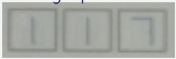

In [12]:
image = Image.open(train_dataset.root_dir + train_df['tps'][0]).convert("RGB")
image

In [13]:
labels = encoding['labels']
labels[labels == -100] = processor.tokenizer.pad_token_id
label_str = processor.decode(labels, skip_special_tokens=True)
print(label_str)

117


## Train a model

Here, we initialize the TrOCR model from its pretrained weights. Note that the weights of the language modeling head are already initialized from pre-training, as the model was already trained to generate text during its pre-training stage. Refer to the paper for details.

In [14]:
from transformers import VisionEncoderDecoderModel

model = VisionEncoderDecoderModel.from_pretrained("microsoft/trocr-small-stage1")

config.json:   0%|          | 0.00/4.21k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/246M [00:00<?, ?B/s]

Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-small-stage1 and are newly initialized: ['encoder.pooler.dense.bias', 'encoder.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


generation_config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Importantly, we need to set a couple of attributes, namely:
* the attributes required for creating the `decoder_input_ids` from the `labels` (the model will automatically create the `decoder_input_ids` by shifting the `labels` one position to the right and prepending the `decoder_start_token_id`, as well as replacing ids which are -100 by the pad_token_id)
* the vocabulary size of the model (for the language modeling head on top of the decoder)
* beam-search related parameters which are used when generating text.

In [15]:
# set special tokens used for creating the decoder_input_ids from the labels
model.config.decoder_start_token_id = processor.tokenizer.cls_token_id
model.config.pad_token_id = processor.tokenizer.pad_token_id
# make sure vocab size is set correctly
model.config.vocab_size = model.config.decoder.vocab_size

# set beam search parameters
model.config.eos_token_id = processor.tokenizer.sep_token_id
model.config.max_length = 64
model.config.early_stopping = True
model.config.no_repeat_ngram_size = 3
model.config.length_penalty = 2.0
model.config.num_beams = 4

Next, we can define some training hyperparameters by instantiating the `training_args`. Note that there are many more parameters, all of which can be found in the [documentation](https://huggingface.co/transformers/main_classes/trainer.html#seq2seqtrainingarguments). You can for example decide what the batch size is for training/evaluation, whether to use mixed precision training (lower memory), the frequency at which you want to save the model, etc.

In [16]:
from transformers import Seq2SeqTrainer, Seq2SeqTrainingArguments

training_args = Seq2SeqTrainingArguments(
    predict_with_generate=True,
    evaluation_strategy="steps",
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    fp16=True,
    output_dir="./",
    logging_steps=2,
    save_steps=1000,
    eval_steps=200,
    num_train_epochs=25,
)

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1494: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


We will evaluate the model on the Character Error Rate (CER), which is available in HuggingFace Datasets (see [here](https://huggingface.co/metrics/cer)).

In [17]:
from datasets import load_metric

cer_metric = load_metric("cer")

<ipython-input-17-c81d87c6f9c2>:3: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  cer_metric = load_metric("cer")
/usr/local/lib/python3.10/dist-packages/datasets/load.py:753: FutureWarning: The repository for cer contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.17.0/metrics/cer/cer.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(


The compute_metrics function takes an `EvalPrediction` (which is a NamedTuple) as input, and should return a dictionary. The model will return an EvalPrediction at evaluation, which consists of 2 things:
* predictions: the predictions by the model.
* label_ids: the actual ground-truth labels.

In [18]:
def compute_metrics(pred):
    labels_ids = pred.label_ids
    pred_ids = pred.predictions

    pred_str = processor.batch_decode(pred_ids, skip_special_tokens=True)
    labels_ids[labels_ids == -100] = processor.tokenizer.pad_token_id
    label_str = processor.batch_decode(labels_ids, skip_special_tokens=True)

    cer = cer_metric.compute(predictions=pred_str, references=label_str)

    return {"cer": cer}

Let's train! We also provide the `default_data_collator` to the Trainer, which is used to batch together examples.

Note that evaluation takes quite a long time, as we're using beam search for decoding, which requires several forward passes for a given example.

In [19]:
from transformers import default_data_collator

# instantiate trainer
trainer = Seq2SeqTrainer(
    model=model,
    tokenizer=processor.feature_extractor,
    args=training_args,
    compute_metrics=compute_metrics,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    data_collator=default_data_collator,
)
trainer.train()

/usr/local/lib/python3.10/dist-packages/transformers/models/trocr/processing_trocr.py:137: FutureWarning: `feature_extractor` is deprecated and will be removed in v5. Use `image_processor` instead.
  warnings.warn(


Step,Training Loss,Validation Loss,Cer
200,0.036200,0.228741,0.073826
400,0.065400,0.127838,0.046980
600,0.001900,0.112552,0.021812
800,0.383900,0.033418,0.008389
1000,0.000300,0.065899,0.023490
1200,0.000200,0.045524,0.006711
1400,0.000100,0.029654,0.008389
1600,0.000000,0.015433,0.006711
1800,0.000000,0.017020,0.006711
2000,0.000000,0.015237,0.005034


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1364: UserWarning: You have modified the pretrained model configuration to control generation. This is a deprecated strategy to control generation and will be removed soon, in a future version. Please use and modify the model generation configuration (see https://huggingface.co/docs/transformers/generation_strategies#default-text-generation-configuration )
  warnings.warn(
Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 64, 'early_stopping': True, 'num_beams': 4, 'length_penalty': 2.0, 'no_repeat_ngram_size': 3}
Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (http

TrainOutput(global_step=3500, training_loss=0.09994368540023424, metrics={'train_runtime': 1104.9355, 'train_samples_per_second': 25.25, 'train_steps_per_second': 3.168, 'total_flos': 3.337528779001037e+18, 'train_loss': 0.09994368540023424, 'epoch': 25.0})

## Inference

Note that after training, you can easily load the model using the .`from_pretrained(output_dir)` method.

For inference on new images, I refer to my inference notebook, that can also be found in my [Transformers Tutorials repository](https://github.com/NielsRogge/Transformers-Tutorials) on Github.

In [20]:
processor = TrOCRProcessor.from_pretrained('microsoft/trocr-small-handwritten')
trained_model = VisionEncoderDecoderModel.from_pretrained('./checkpoint-3500')

In [21]:
def read_image(image_path):
    image = Image.open(image_path).convert('RGB')
    return image

In [22]:
def ocr(image, processor, model):
    pixel_values = processor(image, return_tensors='pt').pixel_values
    generated_ids = model.generate(pixel_values)
    generated_text = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]
    return generated_text

In [23]:
import glob as glob
import matplotlib.pyplot as plt
from PIL import Image
from tqdm.notebook import tqdm
def eval_new_data(data_path,num_samples):
    image_paths = glob.glob(data_path)
    for i, image_path in tqdm(enumerate(image_paths), total=len(image_paths)):
        if i == num_samples:
            break
        image = read_image(image_path)
        text = ocr(image, processor, trained_model)
        plt.figure(figsize=(7, 4))
        plt.imshow(image)
        plt.title(text)
        plt.axis('off')
        plt.show()

  0%|          | 0/117 [00:00<?, ?it/s]

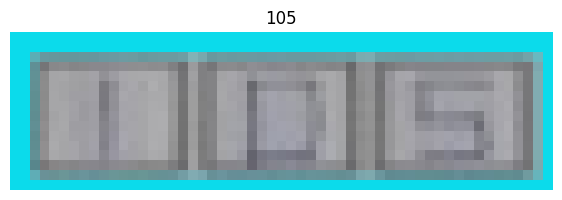

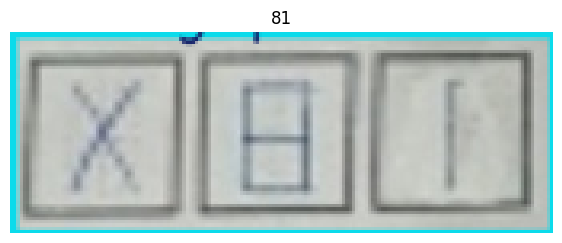

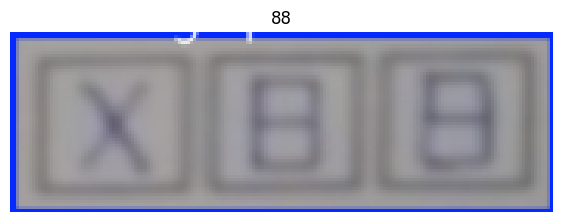

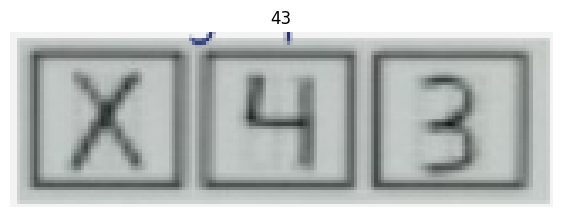

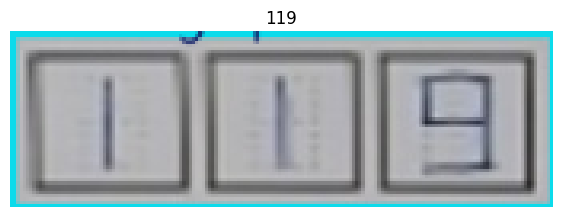

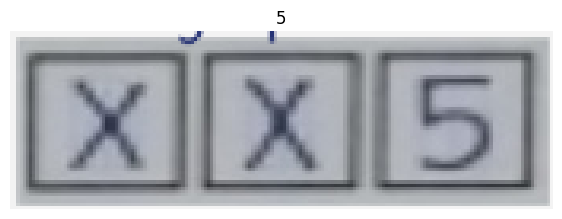

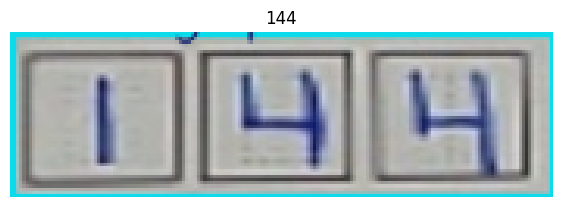

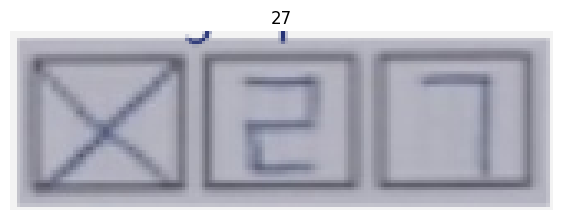

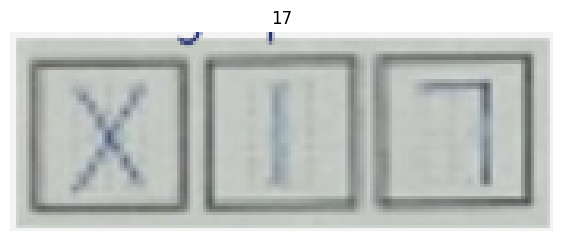

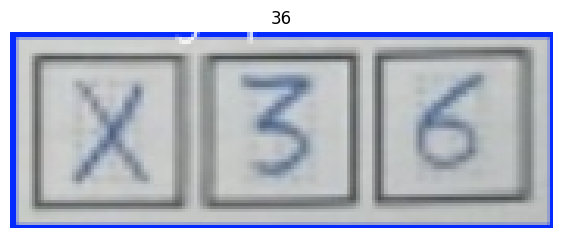

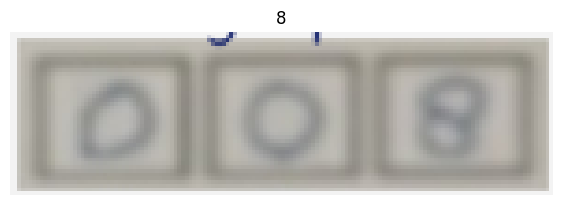

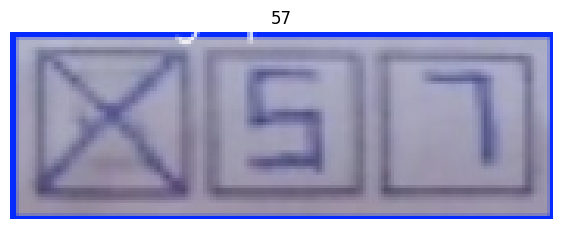

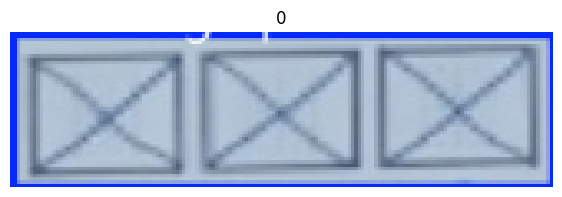

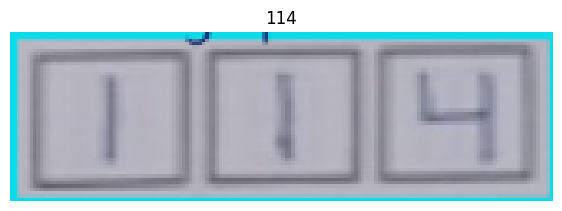

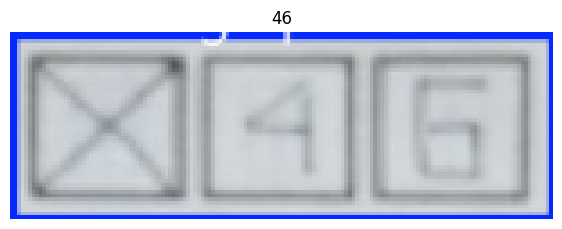

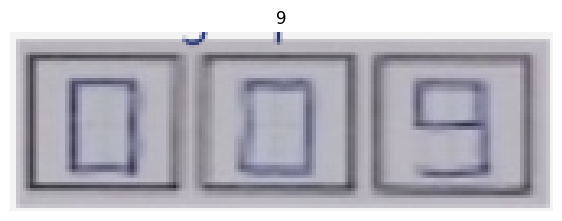

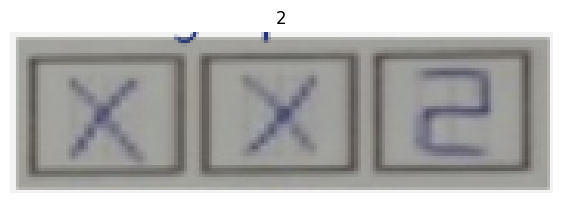

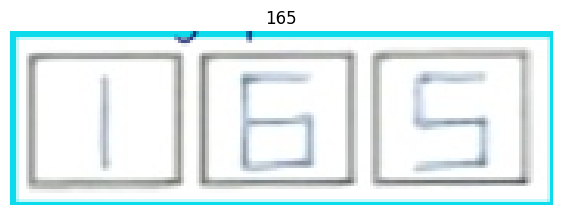

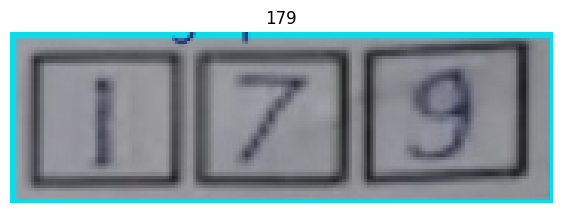

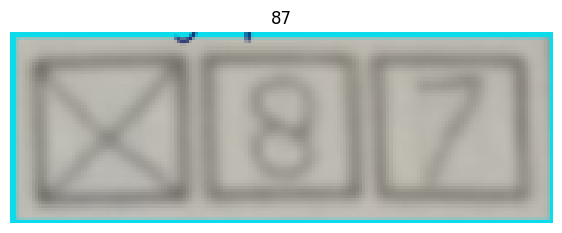

In [25]:
eval_new_data(
    data_path=os.path.join('/content/Dataset_OCR/test', '*'),
    num_samples=20
)